## Loading Dataset directly from Kaggle

In [1]:
import pandas as pd
import os
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#changing the working directory
%cd "/content/drive/MyDrive/Materials/Input"

/content/drive/MyDrive/Materials/Input


In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Materials/Input"

In [4]:
#Downloading the dataset
!kaggle datasets download -d omkargurav/face-mask-dataset

 97% 158M/163M [00:01<00:00, 113MB/s]
100% 163M/163M [00:01<00:00, 93.4MB/s]


In [5]:
pwd

'/content/drive/MyDrive/Materials/Input'

In [ ]:
#Unzipping the File
!unzip \*.zip  && rm *.zip

In [4]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np 
import cv2


In [5]:
# Checking image dimensions
from PIL import Image
  
# get image
filepath = 'data/with_mask/with_mask_1.jpg'
img = Image.open(filepath)
  
# get width and height
width = img.width
height = img.height

print(height, width)

350 525


In [6]:
%cd /content/drive/MyDrive/Materials/Input

/content/drive/MyDrive/Materials/Input


In [7]:
ls

data/  kaggle.json


In [8]:
batch_size = 50
img_height = 200
img_width = 200

data_path='data'

In [9]:
#Splitting Dataset into training and testing
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset= "training",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size
)
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
data_path,
    validation_split=0.2,
    subset= "validation",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size
)

Found 7553 files belonging to 2 classes.
Using 6043 files for training.
Found 7553 files belonging to 2 classes.
Using 1510 files for validation.


In [10]:
#Adding labels to Training Dataset
class_names = training_ds.class_names
class_names

['with_mask', 'without_mask']

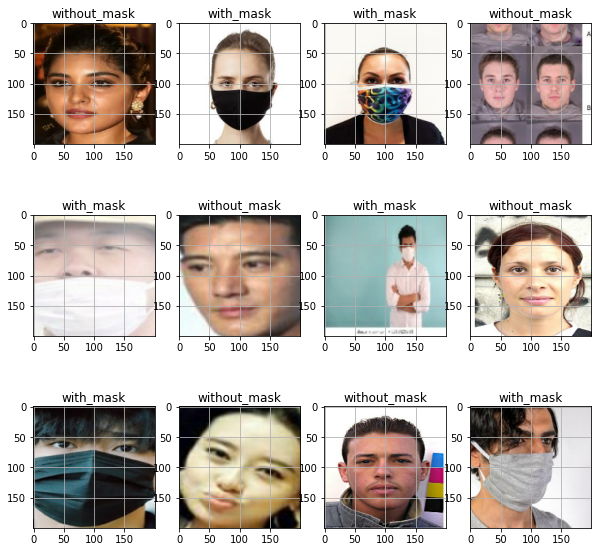

In [11]:
#Plot
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.grid(True)

## The Keras Tuner is a library that helps you pick the optimal set of hyperparameters for your TensorFlow program. The process of selecting the right set of hyperparameters for your machine learning (ML) application is called hyperparameter tuning or hypertuning

In [12]:
## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
AUTOTUNE
training_ds
testing_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [14]:
## Defining the Model
MyCnn = tf.keras.models.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),

  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),

  layers.GlobalAveragePooling2D(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(2, activation= 'softmax')
])

In [15]:
MyCnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
retVal = MyCnn.fit(training_ds, validation_data= testing_ds, epochs = 20)

Epoch 1/20
121/121 [==============================] - 497s 4s/step - loss: 0.5576 - accuracy: 0.7210 - val_loss: 0.4731 - val_accuracy: 0.7695
Epoch 2/20
121/121 [==============================] - 8s 70ms/step - loss: 0.4795 - accuracy: 0.7774 - val_loss: 0.3776 - val_accuracy: 0.8444
Epoch 3/20
121/121 [==============================] - 8s 70ms/step - loss: 0.3490 - accuracy: 0.8524 - val_loss: 0.2712 - val_accuracy: 0.8940
Epoch 4/20
121/121 [==============================] - 8s 70ms/step - loss: 0.2792 - accuracy: 0.8866 - val_loss: 0.2160 - val_accuracy: 0.9232
Epoch 5/20
121/121 [==============================] - 8s 70ms/step - loss: 0.2462 - accuracy: 0.9034 - val_loss: 0.1929 - val_accuracy: 0.9351
Epoch 6/20
121/121 [==============================] - 8s 69ms/step - loss: 0.2254 - accuracy: 0.9179 - val_loss: 0.1846 - val_accuracy: 0.9358
Epoch 7/20
121/121 [==============================] - 8s 70ms/step - loss: 0.2029 - accuracy: 0.9267 - val_loss: 0.1628 - val_accuracy: 0.9450

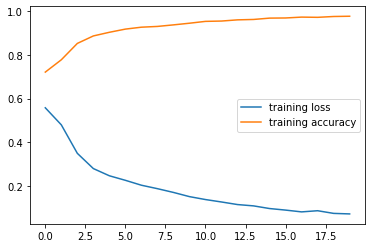

In [17]:
## PLotting the accuracy
plt.plot(retVal.history['loss'], label = 'training loss')
plt.plot(retVal.history['accuracy'], label = 'training accuracy')
plt.legend()

2/2 [==============================] - 1s 174ms/step


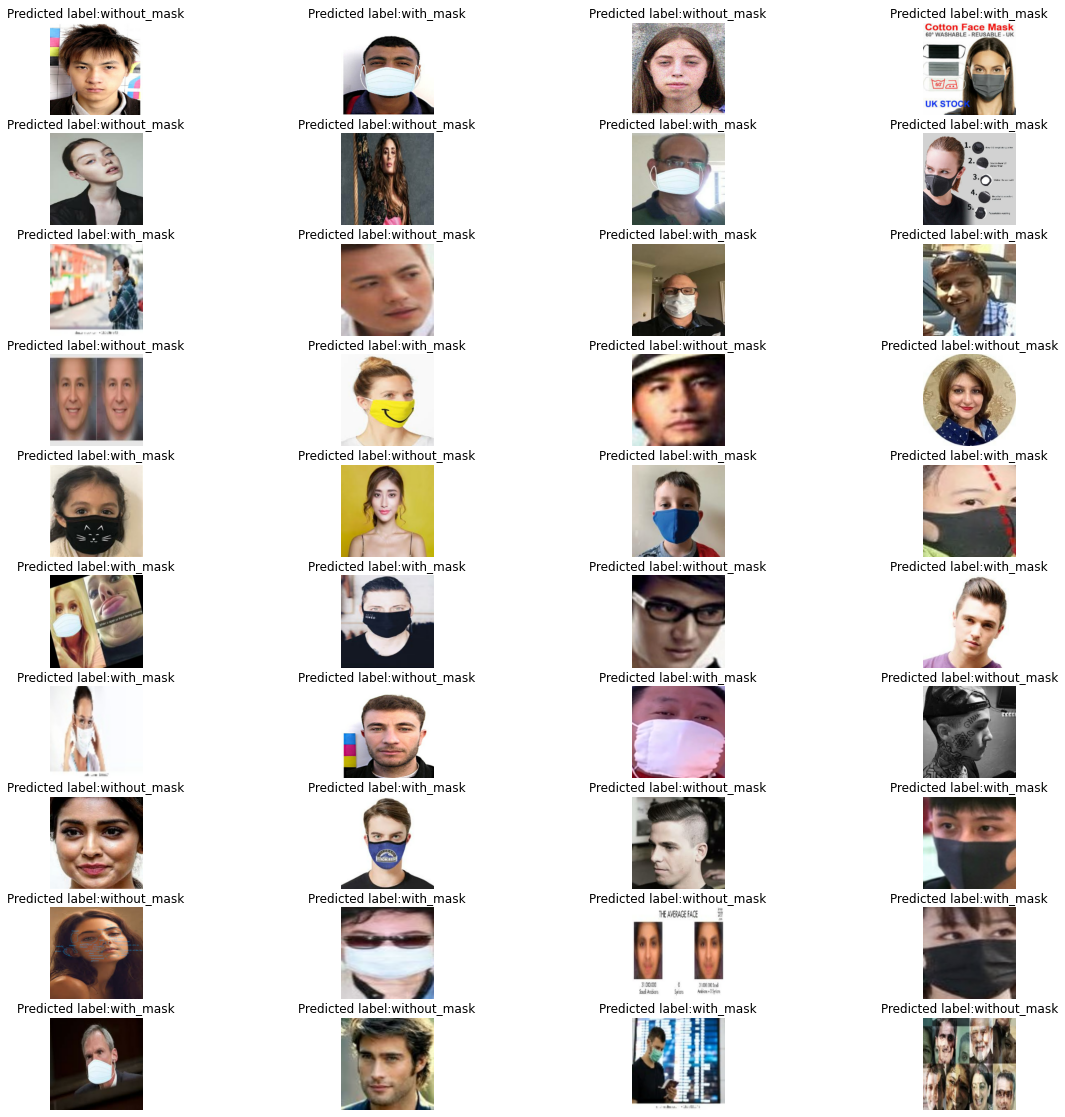

In [18]:
## Preditions

plt.figure(figsize=(20, 20))
for images, labels in testing_ds.take(1):
    predictions = MyCnn.predict(images)
    predlabel = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
    
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicted label:'+ predlabel[i])
        plt.axis('off')
        plt.grid(True)  

In [19]:
def LoadAndDetectObject(path, boxSize = 100, lim = 200):
    img = plt.imread(path)
    img = cv2.resize(img,(200,200))
    numplots = (lim / boxSize)*(lim /boxSize)
    stride = int ((lim - boxSize)/ boxSize)
    
    xCurPos = 0
    yCurPos = 0
    Red = img [:,:,0]
    Blue = img[:,:,1]
    Green = img[:,:,2]
    
    y_pos = 0
    i = 0
    while y_pos < lim:
        x_pos = 0
        while x_pos < lim:
            xCurPos = x_pos
            yCurPos = y_pos
            i += 1
            if i > numplots + 1000:
                cv2.putText(img, 'No Mask', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                plt.imshow(img)
                return
            
            
            r = Red[x_pos : (x_pos + boxSize), y_pos : (y_pos + boxSize)]
            g = Blue[x_pos : (x_pos + boxSize), y_pos : (y_pos + boxSize)]
            b = Green[x_pos : (x_pos + boxSize), y_pos : (y_pos + boxSize)]
            
            ## sanity check
            xx, yy = r.shape
            if xx*yy != boxSize*boxSize:
                x_pos += stride
                continue
               
            imageSegment = cv2.merge((r,g,b))
            imageSegment  = np.array(imageSegment, dtype = 'uint8')
            imageSegment = cv2.resize(imageSegment, (lim, lim))
            result = (MyCnn.predict(np.array([imageSegment])))
            probab = max(result.flatten())
            result = (class_names[np.argmax(result)])
            #print(probab)
            
            if result == 'with_mask' and probab >= 0.8:
                probab = int (probab * 100) / 100
                img = cv2.rectangle(img, (xCurPos,yCurPos), (xCurPos + boxSize, yCurPos + boxSize), (0,255,0), 1) 
                cv2.putText(img, 'Mask', (xCurPos,yCurPos + boxSize), cv2.FONT_HERSHEY_SIMPLEX, 0.7, 1)
                plt.imshow(img)
                return
            
            
            
            
            x_pos += stride
        y_pos += stride
        
    cv2.putText(img, 'No Mask', (100,100), cv2.FONT_HERSHEY_SIMPLEX, 0.7, 1)
    plt.imshow(img)

In [20]:
pwd

'/content/drive/MyDrive/Materials/Input'

1/1 [==============================] - 0s 15ms/step


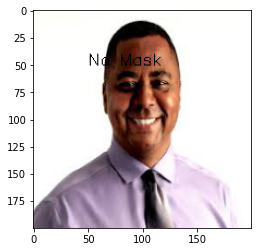

In [25]:
LoadAndDetectObject('m4.jpg')

In [26]:
MyCnn.save('maskDetector.model')